In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
nltk.download('punkt')

import torch
from torch import nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import TensorDataset, Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 676729.86it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 77928.16it/s]


In [ ]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [ ]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

<Figure size 500x800 with 0 Axes>

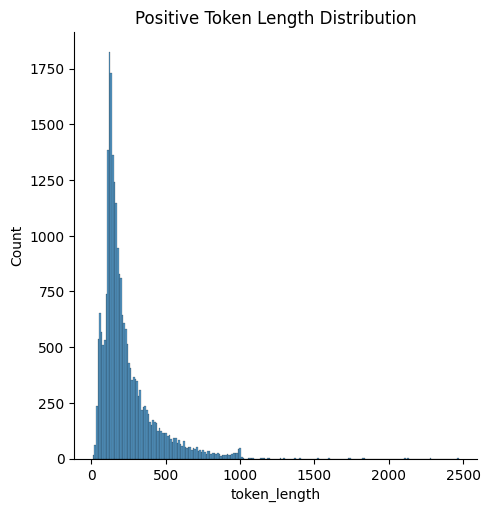

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

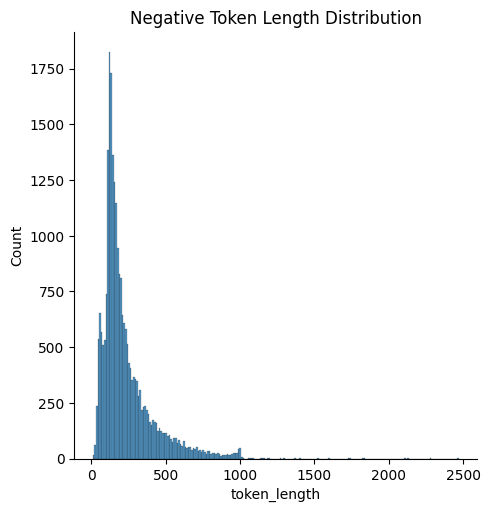

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

In [ ]:
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


# clean and preprocess

In [ ]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)         # remove double whitespaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected


In [ ]:
# Tokenize, Remove stopwords, Lemmatization

def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [ ]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 50000/50000 [01:46<00:00, 468.65it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [ ]:
data[['processed', 'label']].to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/imdb_processed.csv', index=False, header=True)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/transformer/imdb_processed.csv')

for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

# prepare dataset

In [ ]:
reviews = data['processed'].values
# 개별 텍스트 문자열을 공백으로 구분하여 결합
words = ' '.join(reviews)
words = words.split()

words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [ ]:
# build vocabulary

counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'        # <PAD>에 인덱스 0을 할당
word2int = {word: id for id, word in int2word.items()}

In [ ]:
# encode words - 각 토큰을 해당 어휘의 인덱스로 변환

reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

for i in range(5):
    print(reviews_enc[i][:5])

100%|██████████| 50000/50000 [00:02<00:00, 24470.66it/s]

[191, 1083, 930, 81, 3724]
[47, 328, 59, 244, 1]
[3, 95, 328, 30, 1041]
[2408, 136, 59, 241, 3230]
[70982, 10566, 1081, 1941, 7538]


In [ ]:
# padding and trimming - 모든 입력 시퀀스가 동일한 길이 (256)를 갖도록 함

def pad_features(reviews, pad_token, seq_length=128):
    # pad_token 값으로 채움
    features = np.full((len(reviews), seq_length), pad_token, dtype=int)

    for i, row in enumerate(reviews):
        # 행을 원하는 길이로 잘라 seq_length에 맞도록 함
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_token=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  191,  1083,   930,    81,  3724,   186,  3030,     1,   118,
          114],
       [   47,   328,    59,   244,     1,     7,  1267,  1608, 17875,
            4],
       [    3,    95,   328,    30,  1041,    13,   845,  1774,  2633,
            2],
       [ 2408,   136,    59,   241,  3230,    37,   650,  4298,   583,
          882],
       [70982, 10566,  1081,  1941,  7538,  2280,  1313,     6,    46,
            1],
       [ 2795,     4,    13,   368,     5,     2,    17, 42503,     2,
         2952],
       [    3,   197,    18,    10,    21, 12517,  1904, 55922,   121,
         5112],
       [   14,    31,   427,     2,  1342,  4021,   165,    34,  2960,
            1],
       [47893,   980,   359,     6,     3,   180,   776,    81,     6,
            1],
       [   64,    10,   125,  2269,  5606,  1980,    10,     5,     1,
           64]])

In [ ]:
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
class IMDbDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        return torch.tensor(x), torch.tensor(y)


In [ ]:
train_size = 0.7
val_size = 0.5
batch_size = 128

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [ ]:
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


In [ ]:
batch_size = 128

trainset = IMDbDataset(train_x, train_y)
validset = IMDbDataset(val_x, val_y)
testset = IMDbDataset(test_x, test_y)

train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(validset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(testset, shuffle=False, batch_size=batch_size)

In [ ]:
x, y = next(iter(train_loader))

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[    3,    95,    18,  ...,     0,     0,     0],
        [   14,     5,   527,  ...,     0,     0,     0],
        [   14,     5,  1575,  ...,     0,     0,     0],
        ...,
        [  782,  2024,  5915,  ...,     0,     0,     0],
        [ 4564, 14496,  9778,  ...,     0,     0,     0],
        [    3,    34,  5554,  ...,   683,     3,     6]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 0])


# modeling

In [ ]:
# model architecture

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.4):
        super(SentimentModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size, output_size)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = x.long()
        x = self.embedding(x)
        output, _ =  self.lstm(x)       # output :모든 time steps에서의 출력 시퀀스
        output = output[:, -1, :]       # 모든 시퀀스에 대한 출력 시퀀스의 마지막 time step

        output = self.dropout(output)
        output = self.fc(output)

        output = self.sigmoid(output)

        return output

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# model hyperparamters

vocab_size = len(word2int) +1
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.4

model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout).cuda()
print(model)

SentimentModel(
  (embedding): Embedding(121302, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# training

In [ ]:
# training config

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
grad_clip = 5
epochs = 8
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

In [ ]:
def train(model, optimizer, train_loader):
    model.train()
    train_acc, total, train_loss = 0, 0, 0

    for id, (feature, target) in enumerate(train_loader):
        feature, target = feature.cuda(), target.cuda()

        optimizer.zero_grad()

        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        target = target.cuda()
        equals = predicted == target
        train_acc += torch.mean(equals.type(torch.FloatTensor))

        total += target.size(0)
        loss = criterion(out.squeeze(), target.float().cuda())
        train_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        del feature, target

        if id % 50 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(e,
                                                                           id * len(x),
                                                                           len(train_loader),
                                                                           100. * id / len(train_loader),
                                                                           loss.item()))
    avg_loss = train_loss / len(train_loader)
    avg_accuracy = train_acc / total

    return avg_loss, avg_accuracy

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    correct, total, val_loss = 0, 0, 0

    with torch.no_grad():
      for id, (feature, target) in enumerate(val_loader):
          feature, target = feature.cuda(), target.cuda()

          out = model(feature)

          predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
          equals = predicted == target
          correct += torch.mean(equals.type(torch.FloatTensor))

          total += target.size(0)
          loss = criterion(out.squeeze(), target.float().cuda())
          val_loss += loss.item()
          del feature, target, predicted

    avg_loss = val_loss / len(val_loader)
    avg_accuracy = correct / total

    return avg_loss, avg_accuracy

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

val_loss_min = torch.inf
es_trigger = 0
epochs = 8

for e in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)

    print("[EPOCH: %d], Train Loss: %5.2f | Train Accuracy: %5.2f%%" % (e, train_loss, train_accuracy * 100))
    print("[EPOCH: %d], Val Loss: %5.2f | Val Accuracy: %5.2f%%" % (e, val_loss, val_accuracy * 100))

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < val_loss_min:
       val_loss_min = val_loss
       torch.save(model.state_dict(), './sentiment_lstm.pt')
       es_trigger = 0
    else:
       es_trigger += 1

Train Epoch: 1 [0/274 (0%)]	Loss: 0.693618
Train Epoch: 1 [6400/274 (18%)]	Loss: 0.694517
Train Epoch: 1 [12800/274 (36%)]	Loss: 0.688774
Train Epoch: 1 [19200/274 (55%)]	Loss: 0.704227
Train Epoch: 1 [25600/274 (73%)]	Loss: 0.700574
Train Epoch: 1 [32000/274 (91%)]	Loss: 0.693345
[EPOCH: 1], Train Loss:  0.69 | Train Accuracy:  0.40%
[EPOCH: 1], Val Loss:  0.69 | Val Accuracy:  0.40%
Train Epoch: 2 [0/274 (0%)]	Loss: 0.682653
Train Epoch: 2 [6400/274 (18%)]	Loss: 0.676866
Train Epoch: 2 [12800/274 (36%)]	Loss: 0.691890
Train Epoch: 2 [19200/274 (55%)]	Loss: 0.677744
Train Epoch: 2 [25600/274 (73%)]	Loss: 0.689361
Train Epoch: 2 [32000/274 (91%)]	Loss: 0.679891
[EPOCH: 2], Train Loss:  0.69 | Train Accuracy:  0.41%
[EPOCH: 2], Val Loss:  0.69 | Val Accuracy:  0.41%
Train Epoch: 3 [0/274 (0%)]	Loss: 0.688858
Train Epoch: 3 [6400/274 (18%)]	Loss: 0.662332
Train Epoch: 3 [12800/274 (36%)]	Loss: 0.685458
Train Epoch: 3 [19200/274 (55%)]	Loss: 0.675103
Train Epoch: 3 [25600/274 (73%)]	Loss:

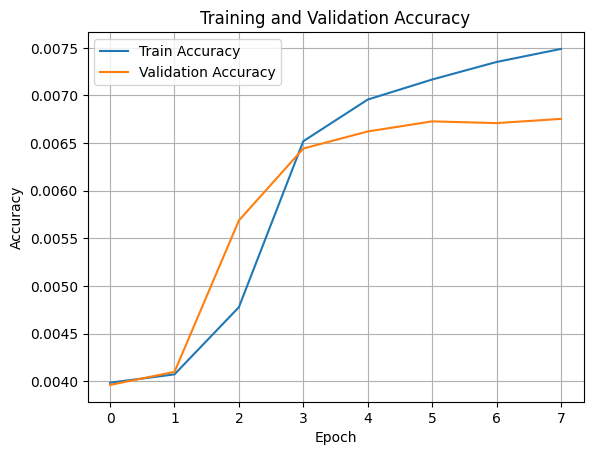

In [ ]:
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

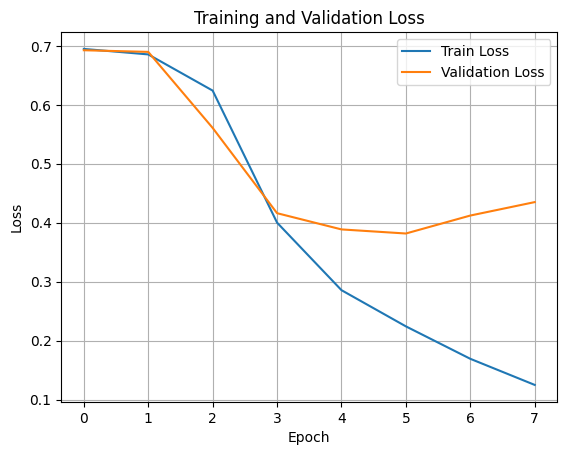

In [ ]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [ ]:
model.eval()

test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

with torch.no_grad():
    for feature, target in test_loader:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(test_loader):.5f}, Loss: {test_loss/len(test_loader):.5f}')

Accuracy: 0.85825, Loss: 0.43626
